In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold,cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,auc
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
!pip install xgboost
import xgboost as xgb




In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

In [ ]:
df=pd.read_csv("/content/sample_data/bank-additional-full.csv",sep=';')

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df["pdays"] = df["pdays"].apply(lambda x: 0 if x == 999 else 1)

In [ ]:
df.previous = df.previous.apply(lambda x: 1 if x > 0 else 0)

In [ ]:
df.drop(df[(df["duration"]==0)].index,inplace=True)

In [ ]:
df['euribor3m*emp.var.rate*nr.employed']=df["euribor3m"]*df["emp.var.rate"]*df["nr.employed"]

In [ ]:
df.drop(["euribor3m","emp.var.rate","nr.employed"],inplace=True,axis=1)

In [ ]:
df[["job","marital","loan","default","housing","education"]]=df[["job","marital","loan","default","housing","education"]].replace("unknown",np.NaN)

In [ ]:

for column in df.columns:
    if df[column].isnull().any():
        mode_value = df[column].mode()[0]
        df[column].fillna(mode_value, inplace=True)


<ipython-input-61-63ebbd299791>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(mode_value, inplace=True)


In [ ]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()


categorical_columns = df.select_dtypes(include=['object']).columns

for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

In [ ]:
X=df.drop("y",axis=1)
y=df["y"]

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)

In [ ]:
scaler=MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from collections import Counter

class_counts = Counter(y_train)
total_samples = len(y_train)

weights = {cls: total_samples / count for cls, count in class_counts.items()}
print("Sınıf Ağırlıkları:", weights)


Sınıf Ağırlıkları: {0: 1.1263593461459545, 1: 8.913937753721244}


# **Models-Strategies**

**SVM-Weighted Class**

Accuracy: 0.8478

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.91      7291
           1       0.42      0.90      0.58       944

    accuracy                           0.85      8235
   macro avg       0.70      0.87      0.74      8235
weighted avg       0.92      0.85      0.87      8235


Confusion Matrix:
[[6132 1159]
 [  94  850]]


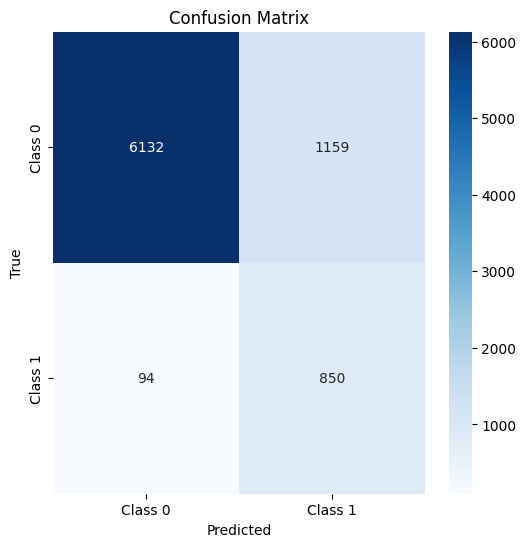

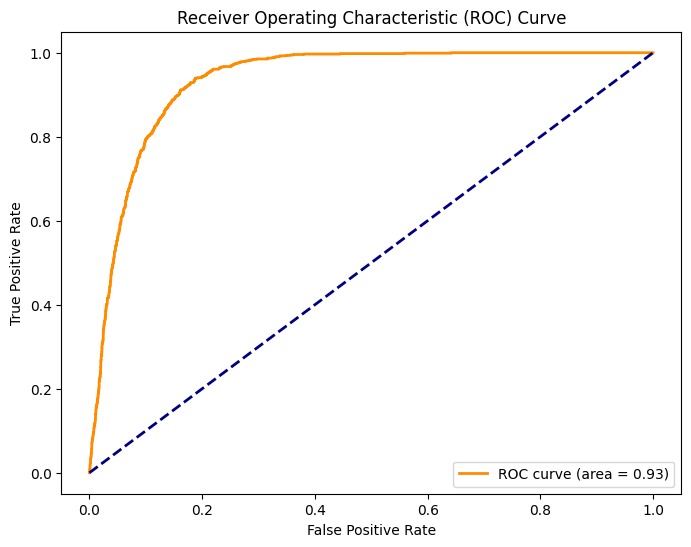


Tuned Model Accuracy: 0.8532

Tuned Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7291
           1       0.43      0.87      0.57       944

    accuracy                           0.85      8235
   macro avg       0.71      0.86      0.74      8235
weighted avg       0.92      0.85      0.87      8235


Tuned Confusion Matrix:
[[6209 1082]
 [ 127  817]]


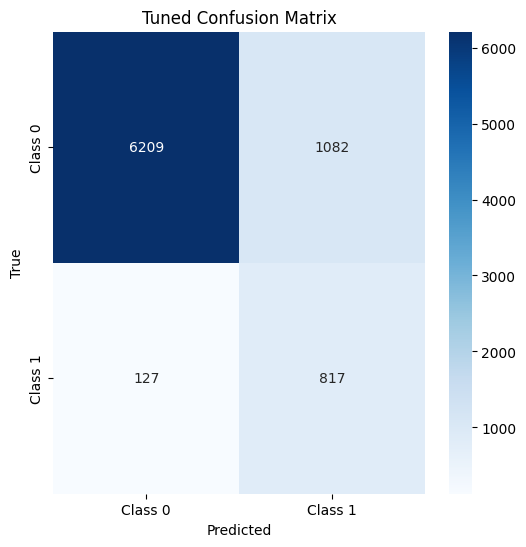

In [ ]:

clf = SVC(class_weight={0: weights[0], 1: weights[1]}, random_state=42)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, clf.decision_function(X_test_scaled))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

clf_tuned = SVC(class_weight={0: weights[0], 1: weights[1]}, C=10, kernel='rbf', random_state=42)
clf_tuned.fit(X_train_scaled, y_train)

y_pred_tuned = clf_tuned.predict(X_test_scaled)

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"\nTuned Model Accuracy: {accuracy_tuned:.4f}")

print("\nTuned Classification Report:")
print(classification_report(y_test, y_pred_tuned))

conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
print("\nTuned Confusion Matrix:")
print(conf_matrix_tuned)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_tuned, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Tuned Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


**Svm-Smote**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Class distribution after SMOTE: [29242 29242]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.85      0.91      7291
           1       0.43      0.88      0.57       944

    accuracy                           0.85      8235
   macro avg       0.70      0.86      0.74      8235
weighted avg       0.92      0.85      0.87      8235

Confusion Matrix:
 [[6186 1105]
 [ 118  826]]
ROC AUC Score: 0.9324926656732586


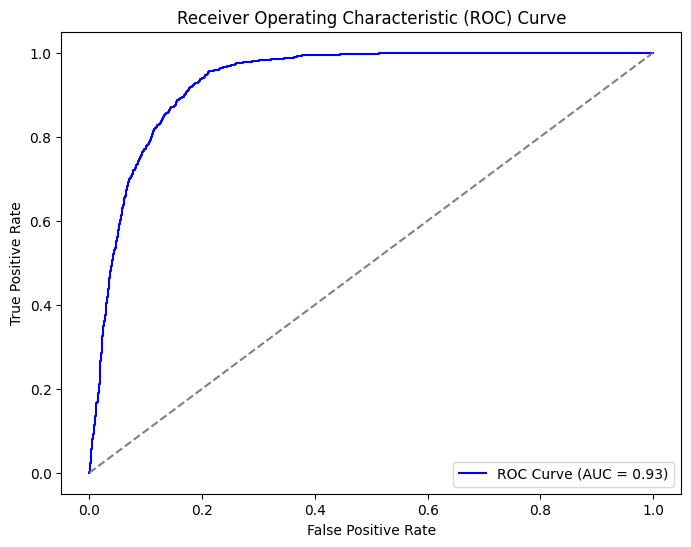

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Class distribution after SMOTE: {np.bincount(y_resampled)}")

svm_clf = SVC(kernel='rbf',class_weight="balanced", C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_resampled, y_resampled)

y_pred = svm_clf.predict(X_test_scaled)

print("Classification Report:\n", classification_report(y_test, y_pred))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

y_prob = svm_clf.decision_function(X_test_scaled)
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Bagging-Classifier-SVM**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix

svm_clf = SVC(kernel='rbf', class_weight='balanced', random_state=42)

ensemble_svm = BaggingClassifier(estimator=svm_clf, n_estimators=10, random_state=42)

ensemble_svm.fit(X_train_scaled, y_train)

y_pred = ensemble_svm.predict(X_test_scaled)


print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Confusion Matrix:
[[6160 1131]
 [ 102  842]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.91      7291
           1       0.43      0.89      0.58       944

    accuracy                           0.85      8235
   macro avg       0.71      0.87      0.74      8235
weighted avg       0.92      0.85      0.87      8235



**Svm-RandomUnderSampler**

Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(



Confusion Matrix:
[[6107 1184]
 [ 106  838]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7291
           1       0.41      0.89      0.57       944

    accuracy                           0.84      8235
   macro avg       0.70      0.86      0.73      8235
weighted avg       0.92      0.84      0.87      8235


ROC AUC Score: 0.93


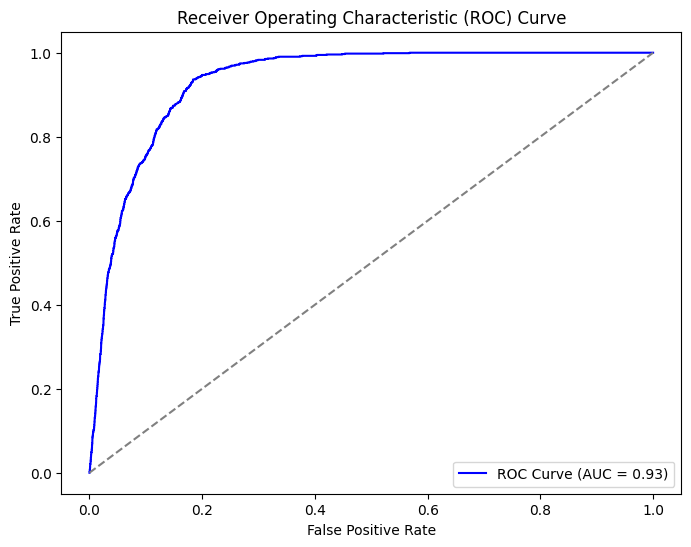

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

svc_clf = SVC(kernel='rbf', probability=True, random_state=42)
svc_clf.fit(X_resampled, y_resampled)

y_pred = svc_clf.predict(X_test_scaled)
y_prob = svc_clf.predict_proba(X_test_scaled)[:, 1]


print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")


fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**SVM-Smoteenn**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Orijinal sınıf dağılımı: [29242  3695]
SMOTE+ENN sonrası sınıf dağılımı: [23899 26969]

Confusion Matrix:
[[6037 1254]
 [  92  852]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7291
           1       0.40      0.90      0.56       944

    accuracy                           0.84      8235
   macro avg       0.69      0.87      0.73      8235
weighted avg       0.92      0.84      0.86      8235


ROC AUC Score: 0.93


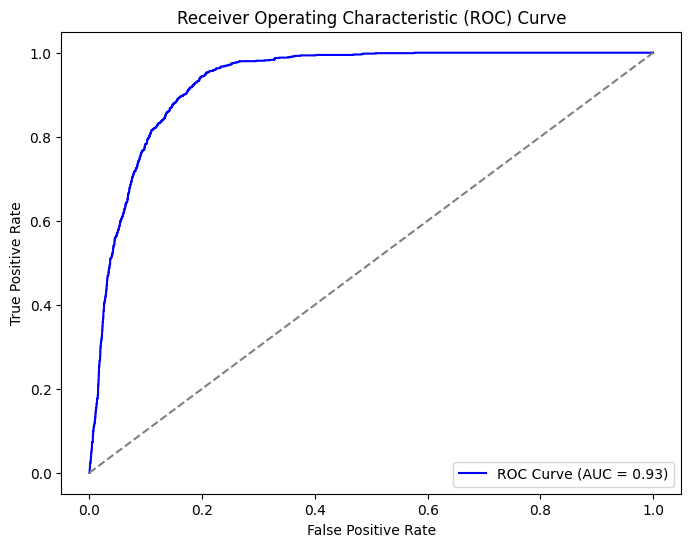

In [ ]:

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTE+ENN sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

svc_clf = SVC(kernel='rbf', probability=True, random_state=42)
svc_clf.fit(X_resampled, y_resampled)

y_pred = svc_clf.predict(X_test_scaled)
y_prob = svc_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Logistic Regression-Weighted Class**

Accuracy: 0.8487

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7291
           1       0.42      0.87      0.57       944

    accuracy                           0.85      8235
   macro avg       0.70      0.86      0.74      8235
weighted avg       0.92      0.85      0.87      8235


Confusion Matrix:
[[6166 1125]
 [ 121  823]]


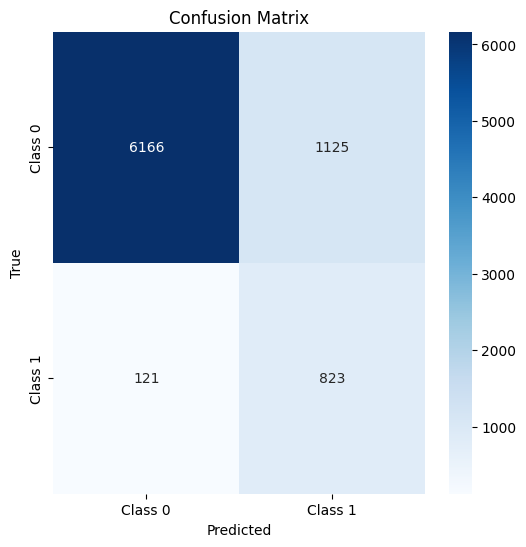

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


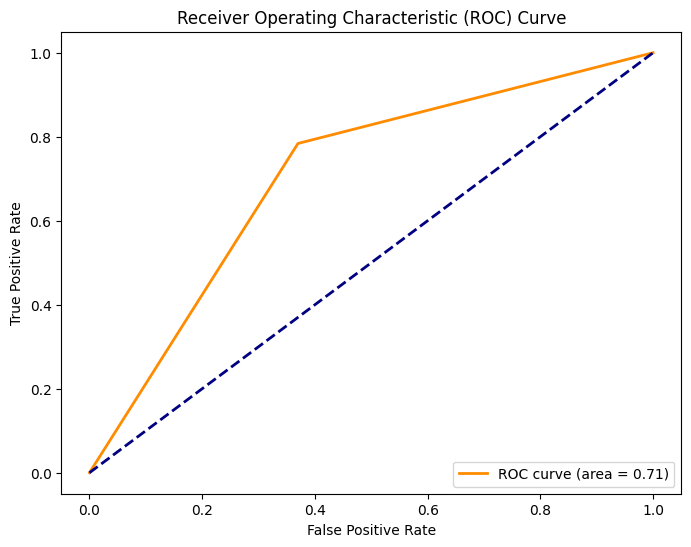


Tuned Model Accuracy: 0.8499

Tuned Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7291
           1       0.42      0.87      0.57       944

    accuracy                           0.85      8235
   macro avg       0.70      0.86      0.74      8235
weighted avg       0.92      0.85      0.87      8235


Tuned Confusion Matrix:
[[6181 1110]
 [ 126  818]]


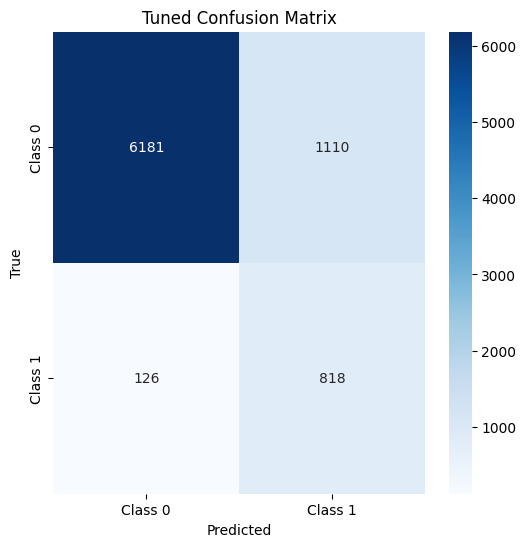

In [ ]:

log_reg = LogisticRegression(class_weight={0: weights[0], 1: weights[1]}, random_state=42, solver='liblinear')
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

log_reg_tuned = LogisticRegression(class_weight={0:weights[0], 1: weights[1] }, random_state=42, C=10, solver='liblinear')
log_reg_tuned.fit(X_train_scaled, y_train)

y_pred_tuned = log_reg_tuned.predict(X_test_scaled)

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"\nTuned Model Accuracy: {accuracy_tuned:.4f}")

print("\nTuned Classification Report:")
print(classification_report(y_test, y_pred_tuned))

conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
print("\nTuned Confusion Matrix:")
print(conf_matrix_tuned)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_tuned, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Tuned Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


**Logistic Regression-Smote**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
SMOTE sonrası sınıf dağılımı: [29242 29242]

Confusion Matrix:
[[6245 1046]
 [ 139  805]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.91      7291
           1       0.43      0.85      0.58       944

    accuracy                           0.86      8235
   macro avg       0.71      0.85      0.74      8235
weighted avg       0.92      0.86      0.87      8235


ROC AUC Score: 0.93


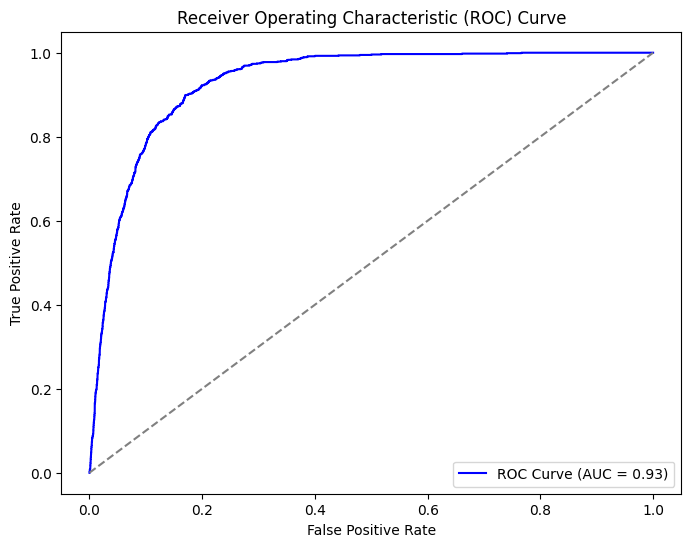

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE



smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTE sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

log_reg = LogisticRegression(class_weight="balanced",solver='liblinear', random_state=42)
log_reg.fit(X_resampled, y_resampled)

y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Logistic Regression-Bagging Classifier**


Confusion Matrix:
[[6054 1237]
 [ 117  827]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7291
           1       0.40      0.88      0.55       944

    accuracy                           0.84      8235
   macro avg       0.69      0.85      0.72      8235
weighted avg       0.91      0.84      0.86      8235


ROC AUC Score: 0.92


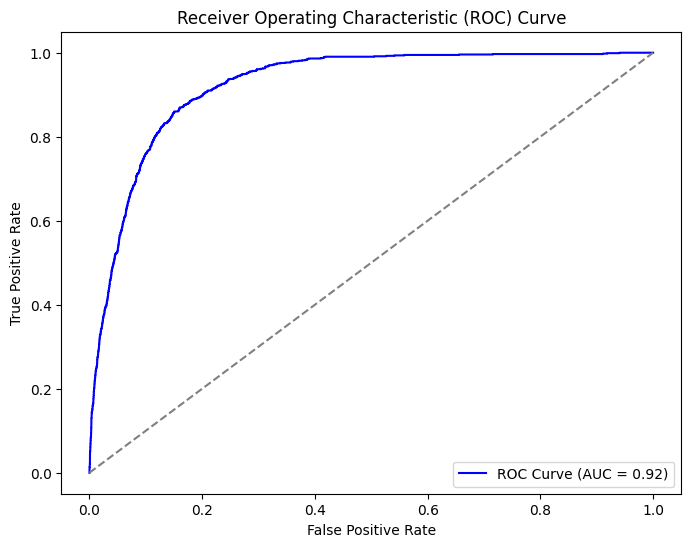

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve




base_model = LogisticRegression(class_weight={0:weights[0], 1: weights[1] },solver='liblinear', random_state=42)
ensemble_model = BaggingClassifier(
    estimator=base_model,
    n_estimators=10,
    random_state=42,
    max_samples=0.8,
    max_features=0.8
)

ensemble_model.fit(X_train_scaled, y_train)

y_pred = ensemble_model.predict(X_test_scaled)
y_prob = ensemble_model.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Logistic Regression-RandomUnderSampling**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]

Confusion Matrix:
[[6155 1136]
 [ 127  817]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.91      7291
           1       0.42      0.87      0.56       944

    accuracy                           0.85      8235
   macro avg       0.70      0.85      0.74      8235
weighted avg       0.92      0.85      0.87      8235


ROC AUC Score: 0.93


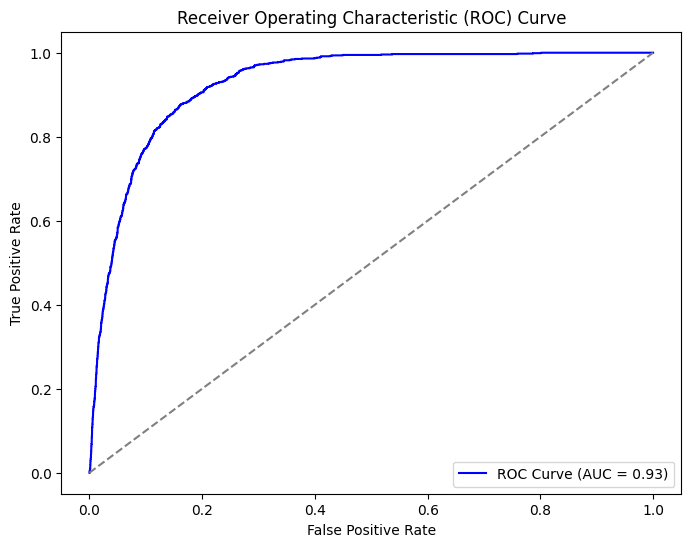

In [ ]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_resampled, y_resampled)

y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



**Logistic Regression-Smoteenn**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Original Class Distribution: [29242  3695]
 After SMOTEENN: [23899 26969]

Confusion Matrix:
[[6005 1286]
 [  99  845]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.82      0.90      7291
           1       0.40      0.90      0.55       944

    accuracy                           0.83      8235
   macro avg       0.69      0.86      0.72      8235
weighted avg       0.92      0.83      0.86      8235


ROC AUC Score: 0.93


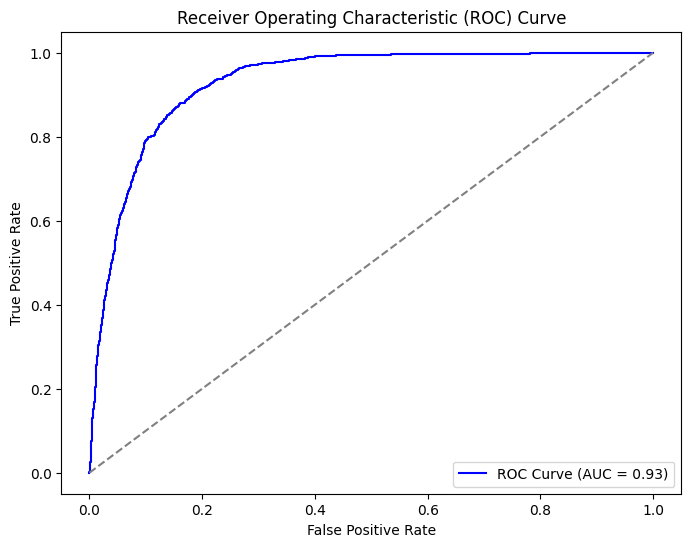

In [ ]:
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Original Class Distribution: {np.bincount(y_train)}")
print(f" After SMOTEENN: {np.bincount(y_resampled)}")

log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_resampled, y_resampled)

y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]  # Pozitif sınıf için olasılıklar

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**GradientBoost-Weighted Class**

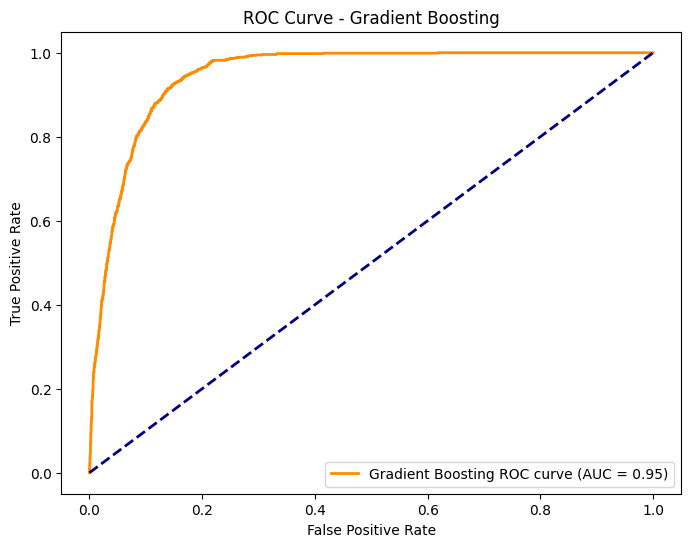


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      7291
           1       0.44      0.93      0.59       944

    accuracy                           0.85      8235
   macro avg       0.71      0.89      0.75      8235
weighted avg       0.93      0.85      0.87      8235



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt

gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

sample_weights = [weights[1] if label == 1 else weights[0]  for label in y_train]

gb.fit(X_train_scaled, y_train, sample_weight=sample_weights)

y_prob_gb = gb.predict_proba(X_test_scaled)[:, 1]

fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2, label='Gradient Boosting ROC curve (AUC = %0.2f)' % roc_auc_gb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc='lower right')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, gb.predict(X_test_scaled)))


**GradientBoost-Smote**

Orijinal sınıf dağılımı: [29242  3695]
SMOTE sonrası sınıf dağılımı: [29242 29242]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(



Confusion Matrix:
[[6573  718]
 [ 173  771]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.94      7291
           1       0.52      0.82      0.63       944

    accuracy                           0.89      8235
   macro avg       0.75      0.86      0.79      8235
weighted avg       0.92      0.89      0.90      8235


ROC AUC Score: 0.94


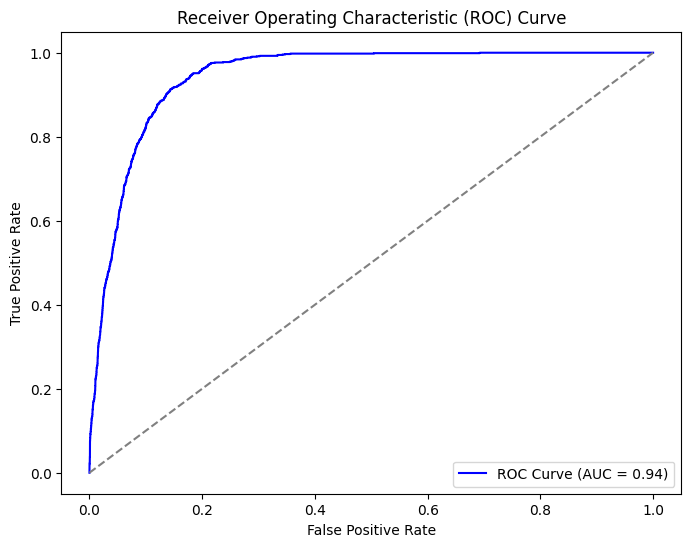

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTE sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_resampled, y_resampled)

y_pred = gb_clf.predict(X_test_scaled)
y_prob = gb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**GradientBoost-RandomUnderSampler**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]

Confusion Matrix:
[[6126 1165]
 [  73  871]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      7291
           1       0.43      0.92      0.58       944

    accuracy                           0.85      8235
   macro avg       0.71      0.88      0.75      8235
weighted avg       0.92      0.85      0.87      8235


ROC AUC Score: 0.94


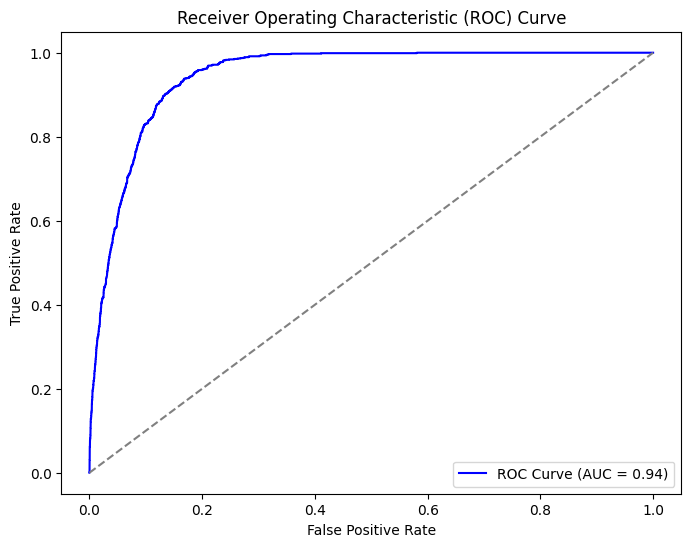

In [ ]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_resampled, y_resampled)

y_pred = gb_clf.predict(X_test_scaled)
y_prob = gb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**GradientBoost-Smoteenn**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Original Class Distribution: [29242  3695]
After SMOTEENN : [23899 26969]

Confusion Matrix:
[[6341  950]
 [ 102  842]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      7291
           1       0.47      0.89      0.62       944

    accuracy                           0.87      8235
   macro avg       0.73      0.88      0.77      8235
weighted avg       0.93      0.87      0.89      8235


ROC AUC Score: 0.94


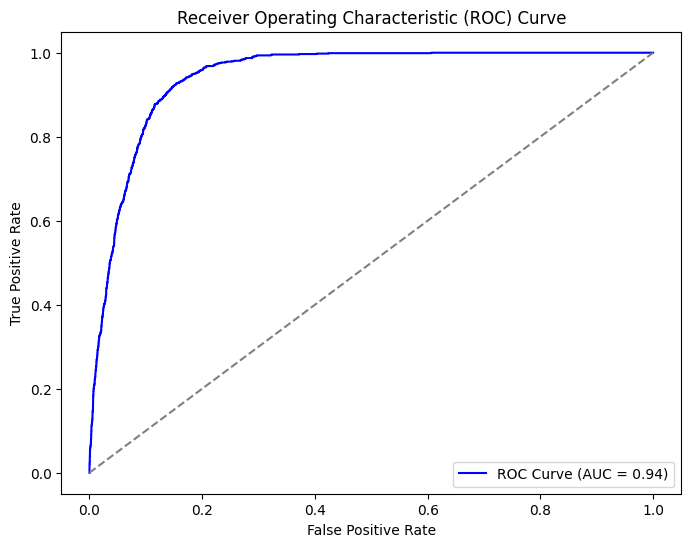

In [ ]:

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Original Class Distribution: {np.bincount(y_train)}")
print(f"After SMOTEENN : {np.bincount(y_resampled)}")

gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_resampled, y_resampled)

y_pred = gb_clf.predict(X_test_scaled)
y_prob = gb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**CatBoost-Weighted Class**

Accuracy: 0.8805

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      7291
           1       0.49      0.90      0.63       944

    accuracy                           0.88      8235
   macro avg       0.74      0.89      0.78      8235
weighted avg       0.93      0.88      0.89      8235


Confusion Matrix:
[[6399  892]
 [  92  852]]


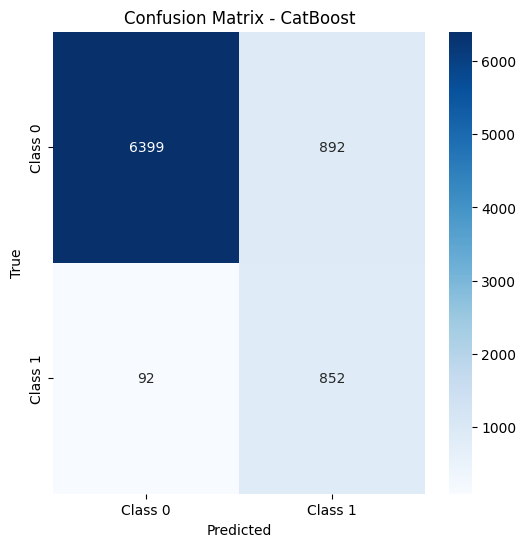

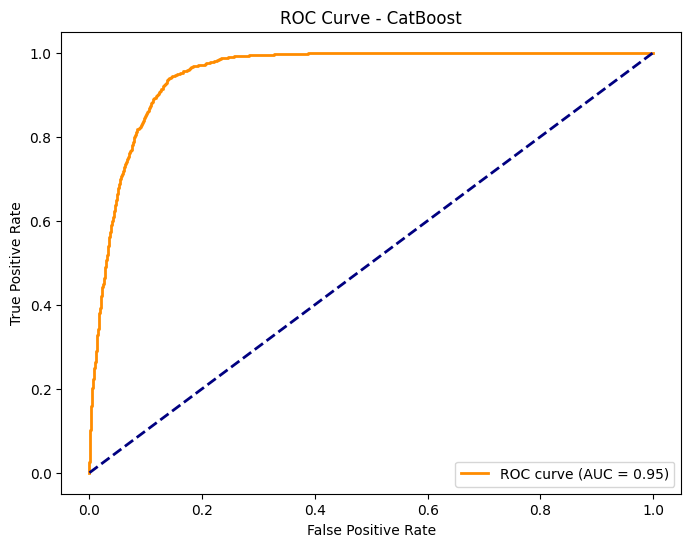

In [ ]:


catboost_model = CatBoostClassifier(iterations=1000, class_weights=[weights[0],weights[1]], random_state=42, verbose=0)

catboost_model.fit(X_train_scaled, y_train)

y_pred_catboost = catboost_model.predict(X_test_scaled)

accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
print(f"Accuracy: {accuracy_catboost:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_catboost))

conf_matrix_catboost = confusion_matrix(y_test, y_pred_catboost)
print("\nConfusion Matrix:")
print(conf_matrix_catboost)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_catboost, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix - CatBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
y_prob_catboost = catboost_model.predict_proba(X_test_scaled)[:, 1]

fpr_catboost, tpr_catboost, _ = roc_curve(y_test, y_prob_catboost)
roc_auc_catboost = auc(fpr_catboost, tpr_catboost)

plt.figure(figsize=(8, 6))
plt.plot(fpr_catboost, tpr_catboost, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_catboost)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost')
plt.legend(loc='lower right')
plt.show()


**CatBoost-Smote**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Original Class Distribution: [29242  3695]
After SMOTE: [29242 29242]

Confusion Matrix:
[[6969  322]
 [ 383  561]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      7291
           1       0.64      0.59      0.61       944

    accuracy                           0.91      8235
   macro avg       0.79      0.78      0.78      8235
weighted avg       0.91      0.91      0.91      8235


ROC AUC Score: 0.95


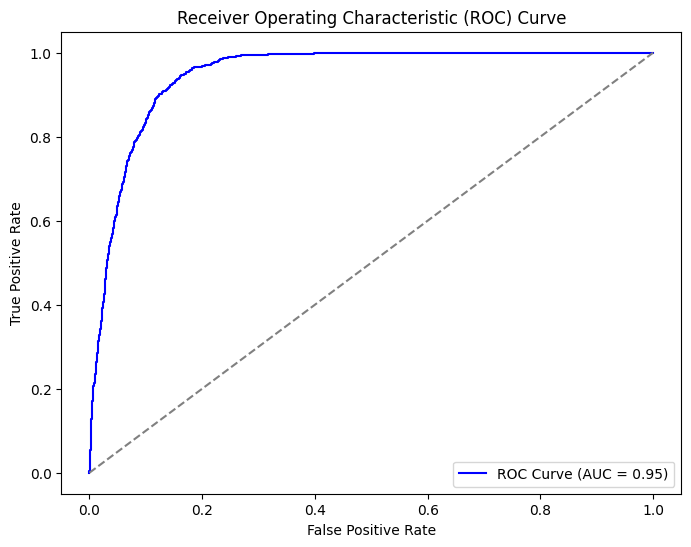

In [ ]:

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Original Class Distribution: {np.bincount(y_train)}")
print(f"After SMOTE: {np.bincount(y_resampled)}")


catboost_clf = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_state=42, verbose=0)
catboost_clf.fit(X_resampled, y_resampled)

y_pred = catboost_clf.predict(X_test_scaled)
y_prob = catboost_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**CatBoost-RandomUnderSampler**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]

Confusion Matrix:
[[6223 1068]
 [  67  877]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      7291
           1       0.45      0.93      0.61       944

    accuracy                           0.86      8235
   macro avg       0.72      0.89      0.76      8235
weighted avg       0.93      0.86      0.88      8235


ROC AUC Score: 0.94


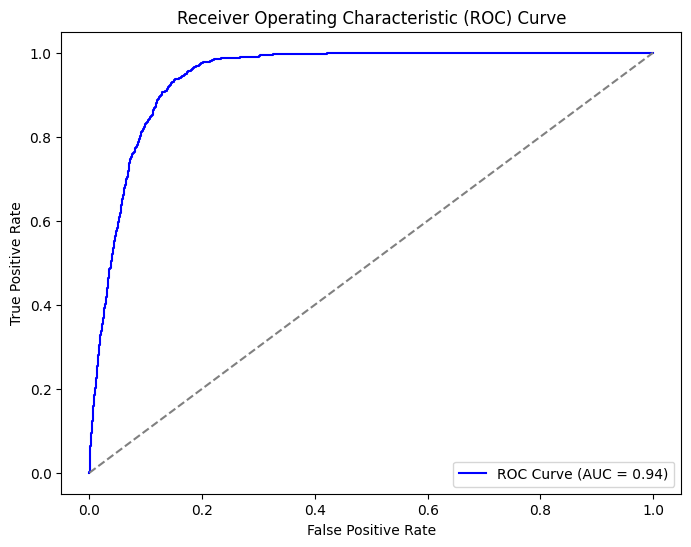

In [ ]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

catboost_clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0
)
catboost_clf.fit(X_resampled, y_resampled)

y_pred = catboost_clf.predict(X_test_scaled)
y_prob = catboost_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**CatBoost-Smoteenn**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Orijinal sınıf dağılımı: [29242  3695]
SMOTEENN sonrası sınıf dağılımı: [23899 26969]

Confusion Matrix:
[[6670  621]
 [ 194  750]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7291
           1       0.55      0.79      0.65       944

    accuracy                           0.90      8235
   macro avg       0.76      0.85      0.80      8235
weighted avg       0.92      0.90      0.91      8235


ROC AUC Score: 0.95


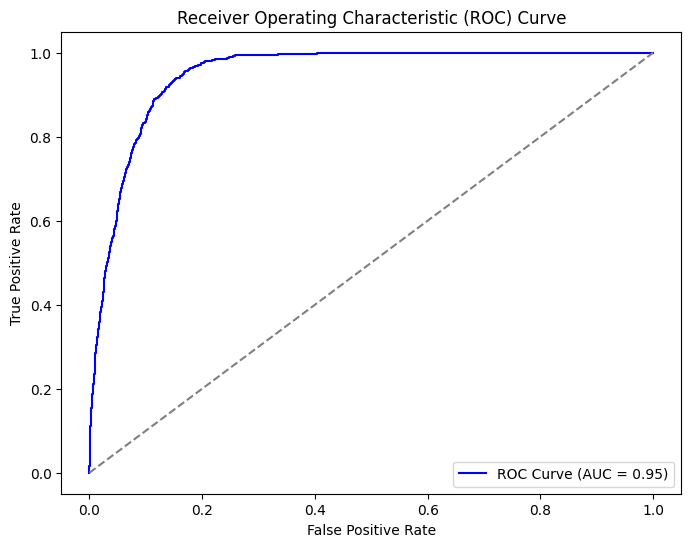

In [ ]:

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTEENN sonrası sınıf dağılımı: {np.bincount(y_resampled)}")


catboost_clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0
)
catboost_clf.fit(X_resampled, y_resampled)

y_pred = catboost_clf.predict(X_test_scaled)
y_prob = catboost_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**XgBoost-Weighted Class**


Confusion Matrix:
[[6280 1011]
 [  71  873]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      7291
           1       0.46      0.92      0.62       944

    accuracy                           0.87      8235
   macro avg       0.73      0.89      0.77      8235
weighted avg       0.93      0.87      0.89      8235


ROC AUC Score: 0.95


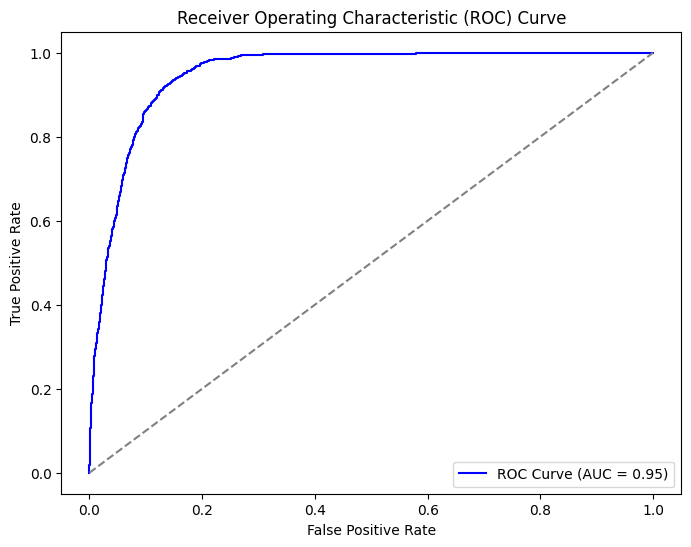

In [ ]:
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

xgb_clf = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

xgb_clf.fit(X_train_scaled, y_train)

y_pred = xgb_clf.predict(X_test_scaled)
y_prob = xgb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**XgBoost-Smote**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
SMOTE sonrası sınıf dağılımı: [29242 29242]

Confusion Matrix:
[[6810  481]
 [ 262  682]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      7291
           1       0.59      0.72      0.65       944

    accuracy                           0.91      8235
   macro avg       0.77      0.83      0.80      8235
weighted avg       0.92      0.91      0.91      8235


ROC AUC Score: 0.95


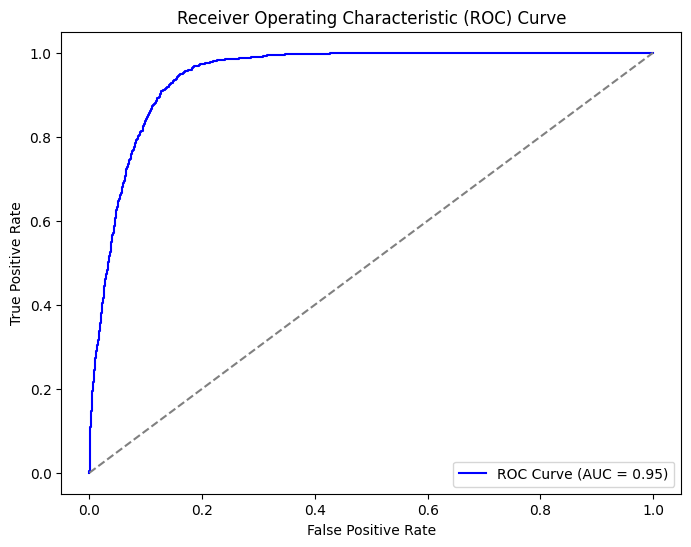

In [ ]:



smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTE sonrası sınıf dağılımı: {np.bincount(y_resampled)}")


xgb_clf = xgb.XGBClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

xgb_clf.fit(X_resampled, y_resampled)

y_pred = xgb_clf.predict(X_test_scaled)
y_prob = xgb_clf.predict_proba(X_test_scaled)[:, 1]


print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**XgBoost-RandomUnderSampler**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]

Confusion Matrix:
[[6182 1109]
 [  58  886]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      7291
           1       0.44      0.94      0.60       944

    accuracy                           0.86      8235
   macro avg       0.72      0.89      0.76      8235
weighted avg       0.93      0.86      0.88      8235


ROC AUC Score: 0.95


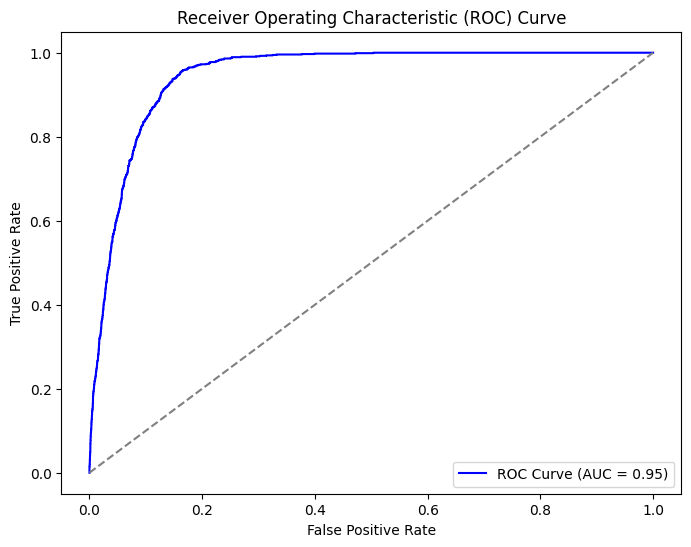

In [ ]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

xgb_clf = xgb.XGBClassifier(
   random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

xgb_clf.fit(X_resampled, y_resampled)

y_pred = xgb_clf.predict(X_test_scaled)
y_prob = xgb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**XgBoost-Smoteenn**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Orijinal sınıf dağılımı: [29242  3695]
SMOTEENN sonrası sınıf dağılımı: [23899 26969]

Confusion Matrix:
[[6547  744]
 [ 153  791]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      7291
           1       0.52      0.84      0.64       944

    accuracy                           0.89      8235
   macro avg       0.75      0.87      0.79      8235
weighted avg       0.92      0.89      0.90      8235


ROC AUC Score: 0.95


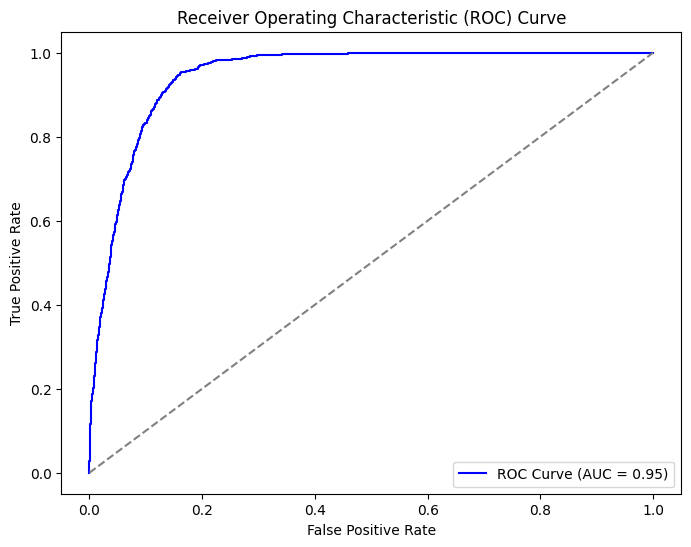

In [ ]:

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTEENN sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

xgb_clf = xgb.XGBClassifier(
  random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

xgb_clf.fit(X_resampled, y_resampled)

y_pred = xgb_clf.predict(X_test_scaled)
y_prob = xgb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**RandomForest-Class Weight**


Confusion Matrix:
[[7100  191]
 [ 522  422]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7291
           1       0.69      0.45      0.54       944

    accuracy                           0.91      8235
   macro avg       0.81      0.71      0.75      8235
weighted avg       0.90      0.91      0.91      8235


ROC AUC Score: 0.95


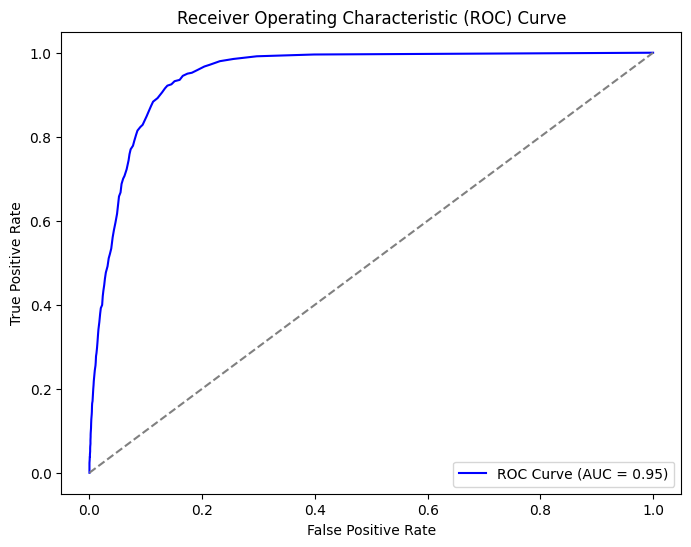

In [ ]:


random_forest_clf = RandomForestClassifier(
    class_weight={0: weights[0],1: weights[1] },
    n_estimators=100,
    random_state=42
)

random_forest_clf.fit(X_train_scaled, y_train)

y_pred = random_forest_clf.predict(X_test_scaled)
y_prob = random_forest_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**RandomForest-Smote**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
SMOTE sonrası sınıf dağılımı: [29242 29242]

Confusion Matrix:
[[6826  465]
 [ 288  656]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7291
           1       0.59      0.69      0.64       944

    accuracy                           0.91      8235
   macro avg       0.77      0.82      0.79      8235
weighted avg       0.92      0.91      0.91      8235


ROC AUC Score: 0.94


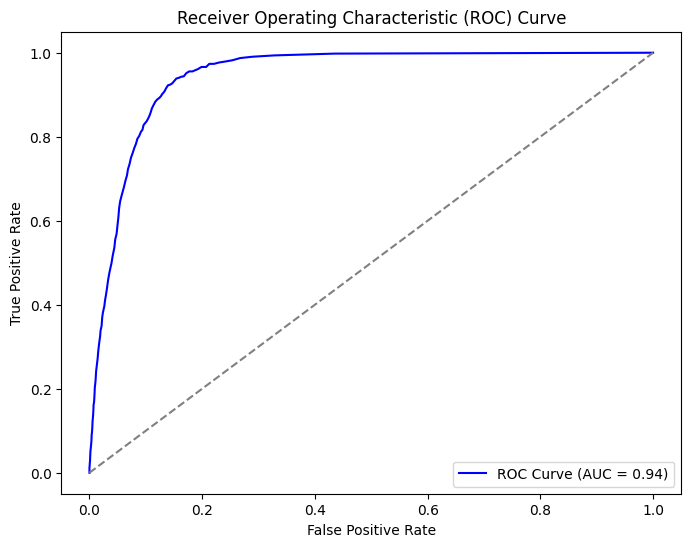

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTE sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

random_forest_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

random_forest_clf.fit(X_resampled, y_resampled)


y_pred = random_forest_clf.predict(X_test_scaled)
y_prob = random_forest_clf.predict_proba(X_test_scaled)[:, 1]
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**RandomForest-RandomUnderSampler**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]

Confusion Matrix:
[[6146 1145]
 [  65  879]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      7291
           1       0.43      0.93      0.59       944

    accuracy                           0.85      8235
   macro avg       0.71      0.89      0.75      8235
weighted avg       0.93      0.85      0.87      8235


ROC AUC Score: 0.94


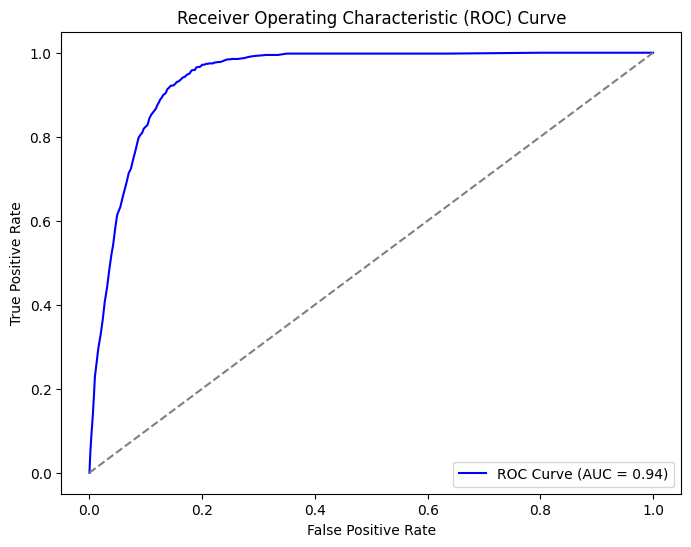

In [ ]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf_clf.fit(X_resampled, y_resampled)

y_pred = rf_clf.predict(X_test_scaled)
y_prob = rf_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**RandomForest-Smoteen**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Orijinal sınıf dağılımı: [29242  3695]
SMOTEENN sonrası sınıf dağılımı: [23899 26969]

Confusion Matrix:
[[6547  744]
 [ 157  787]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      7291
           1       0.51      0.83      0.64       944

    accuracy                           0.89      8235
   macro avg       0.75      0.87      0.79      8235
weighted avg       0.92      0.89      0.90      8235


ROC AUC Score: 0.94


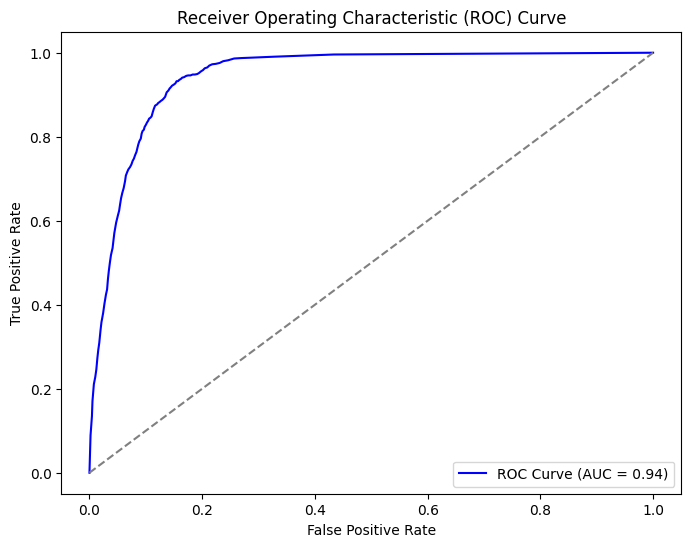

In [ ]:

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTEENN sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf_clf.fit(X_resampled, y_resampled)

y_pred = rf_clf.predict(X_test_scaled)
y_prob = rf_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# **Neural Networks**

**Focal Loss**

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
def focal_loss(alpha=0.9090367403237989, gamma=4.202187396549279):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        weight = y_true * (1 - y_pred)**gamma + (1 - y_true) * y_pred**gamma
        return tf.reduce_mean(alpha * weight * cross_entropy)
    return loss


model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss=focal_loss(alpha=0.9090367403237989, gamma=4.202187396549279),
    metrics=['accuracy', tf.keras.metrics.Recall()]
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=20,
    batch_size=16
)

test_loss, test_accuracy, test_recall = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Recall: {test_recall:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8643 - loss: 0.0208 - recall: 0.0717 - val_accuracy: 0.9061 - val_loss: 0.0118 - val_recall: 0.3898
Epoch 2/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9048 - loss: 0.0116 - recall: 0.3910 - val_accuracy: 0.9060 - val_loss: 0.0112 - val_recall: 0.3517
Epoch 3/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9053 - loss: 0.0109 - recall: 0.4442 - val_accuracy: 0.9066 - val_loss: 0.0107 - val_recall: 0.3612
Epoch 4/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9092 - loss: 0.0107 - recall: 0.4027 - val_accuracy: 0.9078 - val_loss: 0.0105 - val_recall: 0.5000
Epoch 5/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9063 - loss: 0.0107 - recall: 0.4205 - val_accuracy: 0.9058 - val_loss: 0.0108 - val_recall: 0.5042
Epoch 6/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9081 - loss: 0.0104 - recall: 0.3990 - val_accuracy: 0.9054 - val_loss: 0.0108 - val_recall

In [ ]:
import optuna
from sklearn.metrics import recall_score

def objective(trial):
    alpha = trial.suggest_float("alpha", 0.1, 1.0)
    gamma = trial.suggest_float("gamma", 1.0, 5.0)

    model.compile(optimizer='adam', loss=focal_loss(alpha=alpha, gamma=gamma), metrics=['accuracy'])
    model.fit(X_train_scaled, y_train, epochs=10, batch_size=16, verbose=0)

    y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
    return recall_score(y_test, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

print(f"Best Parameters: {study.best_params}")


[I 2025-01-01 20:06:08,997] A new study created in memory with name: no-name-56f86e4c-b9ba-4675-9134-5b0ea6c56377


258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-01-01 20:06:55,351] Trial 0 finished with value: 0.3728813559322034 and parameters: {'alpha': 0.7975840995932401, 'gamma': 1.6573890098855468}. Best is trial 0 with value: 0.3728813559322034.


258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-01-01 20:07:42,992] Trial 1 finished with value: 0.4925847457627119 and parameters: {'alpha': 0.677813615694064, 'gamma': 3.1719166200640165}. Best is trial 1 with value: 0.4925847457627119.


258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-01-01 20:08:23,760] Trial 2 finished with value: 0.4555084745762712 and parameters: {'alpha': 0.4547699926251726, 'gamma': 3.1958189022777965}. Best is trial 1 with value: 0.4925847457627119.


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-01-01 20:09:09,095] Trial 3 finished with value: 0.4427966101694915 and parameters: {'alpha': 0.7161554219536395, 'gamma': 3.439645290050195}. Best is trial 1 with value: 0.4925847457627119.


258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-01-01 20:09:52,309] Trial 4 finished with value: 0.573093220338983 and parameters: {'alpha': 0.1266211325729101, 'gamma': 1.5768704489334708}. Best is trial 4 with value: 0.573093220338983.


Best Parameters: {'alpha': 0.1266211325729101, 'gamma': 1.5768704489334708}


In [ ]:
def focal_loss(alpha=0.1266211325729101, gamma=1.5768704489334708):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        weight = y_true * (1 - y_pred)**gamma + (1 - y_true) * y_pred**gamma
        return tf.reduce_mean(alpha * weight * cross_entropy)
    return loss


model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss=focal_loss(alpha= 0.1266211325729101, gamma= 1.5768704489334708),
    metrics=['accuracy', tf.keras.metrics.Recall()]
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=20,
    batch_size=16
)

test_loss, test_accuracy, test_recall = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Recall: {test_recall:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.8798 - loss: 0.0050 - recall_1: 0.1470 - val_accuracy: 0.9021 - val_loss: 0.0036 - val_recall_1: 0.2436
Epoch 2/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9032 - loss: 0.0035 - recall_1: 0.3009 - val_accuracy: 0.9056 - val_loss: 0.0032 - val_recall_1: 0.4809
Epoch 3/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9070 - loss: 0.0031 - recall_1: 0.3972 - val_accuracy: 0.9089 - val_loss: 0.0031 - val_recall_1: 0.5053
Epoch 4/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9092 - loss: 0.0030 - recall_1: 0.4039 - val_accuracy: 0.9070 - val_loss: 0.0030 - val_recall_1: 0.3909
Epoch 5/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9093 - loss: 0.0030 - recall_1: 0.4021 - val_accuracy: 0.9081 - val_loss: 0.0030 - val_recall_1: 0.4407
Epoch 6/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9088 - loss: 0.0030 - recall_1: 0.4353 - val_accuracy: 0.9100 - val_los

**Weighted Binary Crossentropy**

In [ ]:
import tensorflow as tf
def weighted_binary_crossentropy(weight):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        weights_vec = y_true * weight[1] + (1 - y_true) * weight[0]
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        return tf.reduce_mean(weights_vec * bce)
    return loss


model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss=weighted_binary_crossentropy(weight=[weights[0], weights[1]]),
    metrics=['accuracy', tf.keras.metrics.Recall()]
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=6,
    batch_size=16
)

test_loss, test_accuracy, test_recall = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Recall: {test_recall:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.8926 - loss: 0.7401 - recall_3: 0.0848 - val_accuracy: 0.9047 - val_loss: 0.5101 - val_recall_3: 0.3867
Epoch 2/6
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9061 - loss: 0.4891 - recall_3: 0.3997 - val_accuracy: 0.9081 - val_loss: 0.4612 - val_recall_3: 0.4343
Epoch 3/6
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9082 - loss: 0.4584 - recall_3: 0.5119 - val_accuracy: 0.9080 - val_loss: 0.4419 - val_recall_3: 0.5381
Epoch 4/6
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9053 - loss: 0.4610 - recall_3: 0.5473 - val_accuracy: 0.9088 - val_loss: 0.4382 - val_recall_3: 0.5360
Epoch 5/6
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9081 - loss: 0.4432 - recall_3: 0.5403 - val_accuracy: 0.9027 - val_loss: 0.4469 - val_recall_3: 0.6748
Epoch 6/6
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9088 - loss: 0.4364 - recall_3: 0.5710 - val_accuracy: 0.9046 - val_loss: 0.4

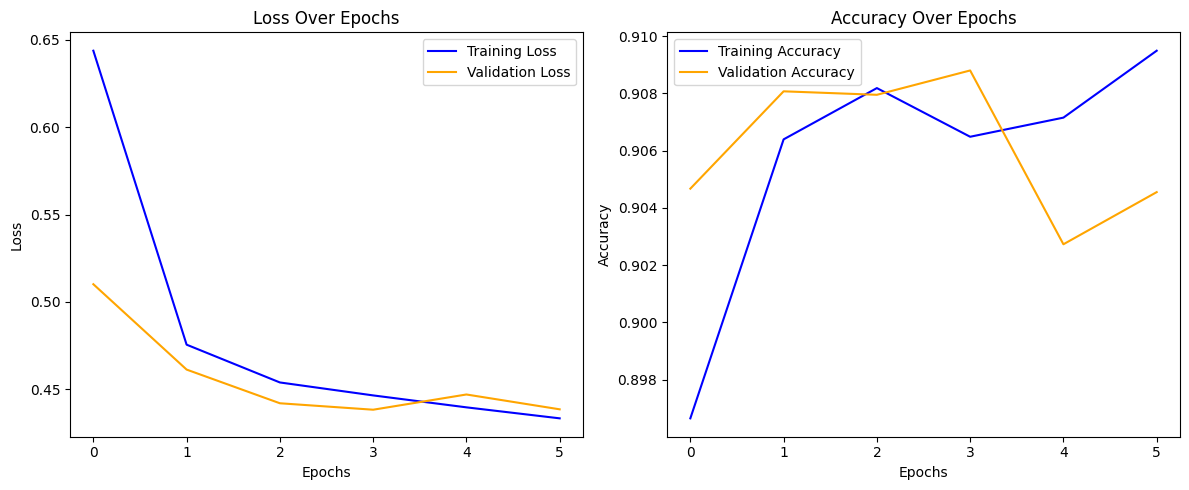

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


# **Best Model Feature Selection**

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

xgb_clf = xgb.XGBClassifier(
   random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

best_model=xgb_clf.fit(X_resampled, y_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]


In [ ]:
feature_importance=best_model.feature_importances_
gbt_fi_df=pd.DataFrame({"Feature" : X.columns, "Importance": feature_importance})
gbt_fi_df=gbt_fi_df.sort_values(by="Importance",ascending=False)
gbt_fi_df

,Feature,Importance
10,duration,0.223731
16,cons.conf.idx,0.193634
17,euribor3m*emp.var.rate*nr.employed,0.166665
12,pdays,0.078913
14,poutcome,0.049131
8,month,0.036843
13,previous,0.029817
7,contact,0.027868
15,cons.price.idx,0.026491
9,day_of_week,0.025085


In [ ]:
Selected_Features=list(gbt_fi_df[gbt_fi_df["Importance"]>0.03].Feature)

In [ ]:
Selected_Features.append("y")

In [ ]:
df_new=df[Selected_Features]
df_new.head()

,duration,cons.conf.idx,euribor3m*emp.var.rate*nr.employed,pdays,poutcome,month,y
0,261,-36.4,27733.9557,0,1,6,0
1,149,-36.4,27733.9557,0,1,6,0
2,226,-36.4,27733.9557,0,1,6,0
3,151,-36.4,27733.9557,0,1,6,0
4,307,-36.4,27733.9557,0,1,6,0


In [ ]:
X=df_new.drop("y",axis=1)
y=df_new["y"]

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

In [ ]:
scaler=MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]

Confusion Matrix:
[[6066 1225]
 [  50  894]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      7291
           1       0.42      0.95      0.58       944

    accuracy                           0.85      8235
   macro avg       0.71      0.89      0.74      8235
weighted avg       0.93      0.85      0.87      8235


ROC AUC Score: 0.95


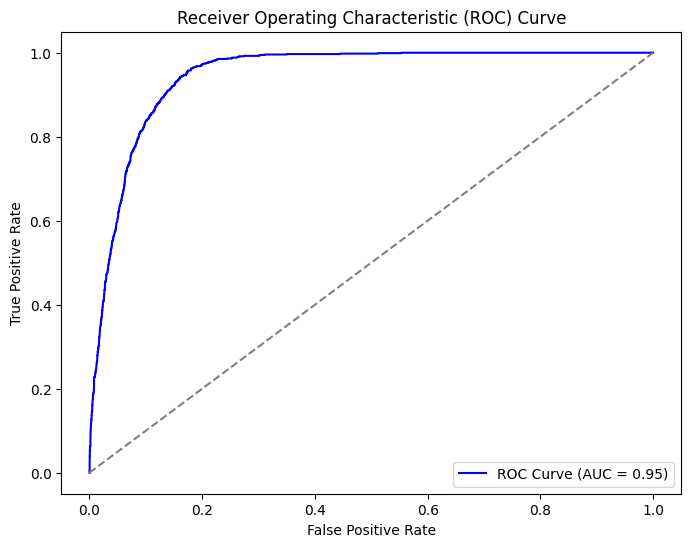

In [ ]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

xgb_clf = xgb.XGBClassifier(
   random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

xgb_clf.fit(X_resampled, y_resampled)

y_pred = xgb_clf.predict(X_test_scaled)
y_prob = xgb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
